# Simulation of Basic Fourier Ptychograpghy



**Simulate the high resoluiton complex object **


In [63]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import cv2
import random
import aotools.functions.zernike as optool

def Ft(input):
    return np.fft.ifft2(np.fft.ifftshift(input))
def F(input):
    return np.fft.fftshift(np.fft.fft2(input))


 **Simulate the forward imaging process of Fourier ptychography**
 
 1. setup the parameters for the spatially coherent imaging system
 

In [64]:
#parameter for illumination
waveLength = 0.518e-6;    #사용된 빛의 종류   ## fixed
k0 = 2*np.pi/waveLength; #wavevector

#parameter for camera
mag = 3.3; # fixed
sensor_psize = 2.4e-6;        #sampling pixel size of the camera  ## fixed
#parameter for simulation (Ground Truth)
psize = 0.2e-6 #the pixel size of the final reconstructed super-resolution image
sensor_size_x=200   
sensor_size_y=200     

#parameter for Imaging System
NA = 0.1;               #NA of 대물렌즈  ## fixed
arraysize = 17;    ## vary (determines number of image)
LEDgap = 4; # 4mm between adjacent LEDs  ## fixed
LEDheight = 50; # distance bewteen the LED matrix and the sample  ## vary 20~100

#calculation for sampling criterion/ overlap percentage in Fourier Domain
# sampling criteron should be larger than 1 to avoid aliasing
# overlap percentage is enough for value between 0.3~0.8
r_cam=(waveLength/NA)*mag/(2*sensor_psize);
r_led=NA*(LEDgap**2+LEDheight**2)**0.5/LEDgap;
if(r_led>1/2):
    r_overlap=(2*np.arccos(1/(2*r_led))-((1-(1/(2*r_led))**2)**0.5)/r_led)/np.pi;
else:
    r_overlap=0;
print('sampling criterion: ', '%.2f' % r_cam, ', overlap percentage: ','%.2f' %r_overlap, )

# calculate effective sampling pixel size and corresponding size of object function
spsize=sensor_psize/mag #effective sampling pixel size
HR_obj_size_x=int(sensor_size_x/(psize/spsize))     
HR_obj_size_y=int(sensor_size_y/(psize/spsize))     



sampling criterion:  3.56 , overlap percentage:  0.51


<Figure size 432x288 with 0 Axes>

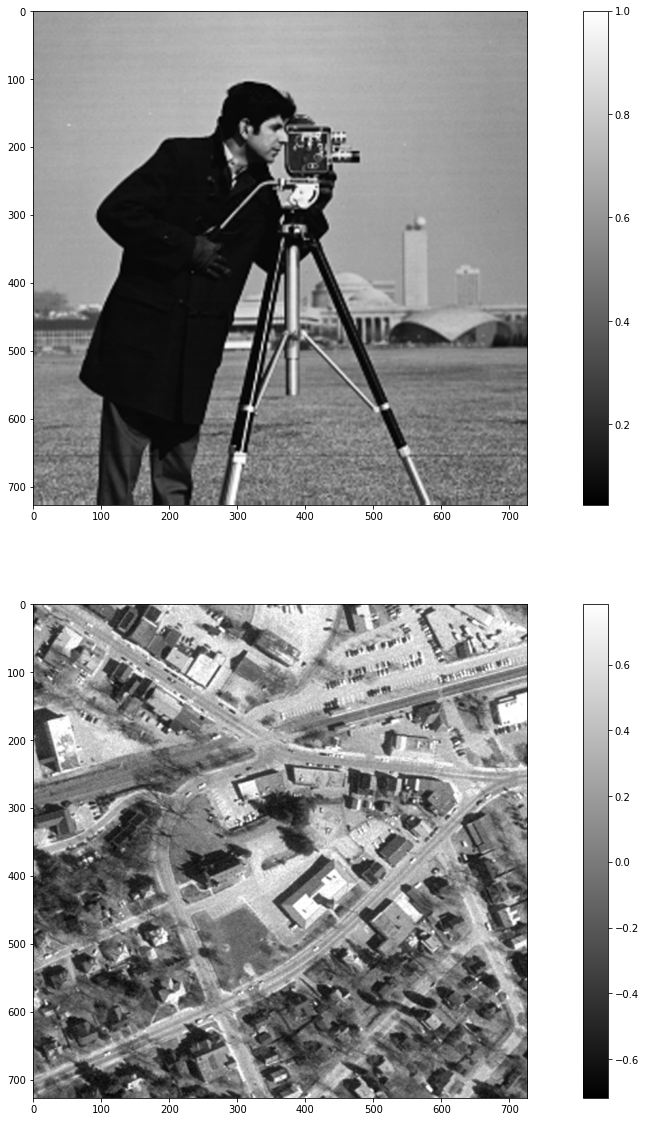

<Figure size 432x288 with 0 Axes>

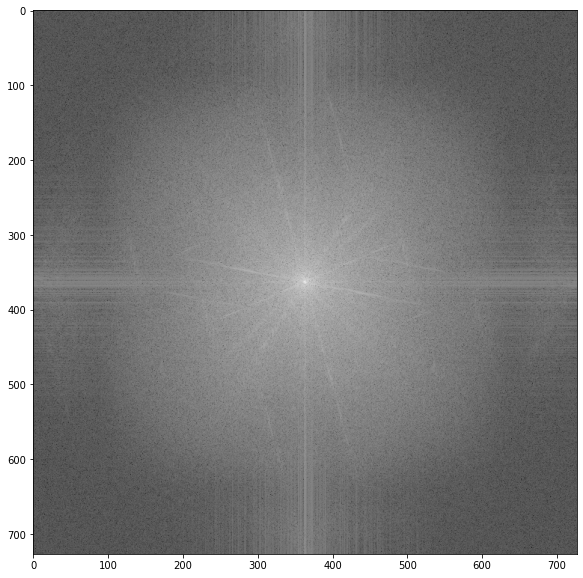

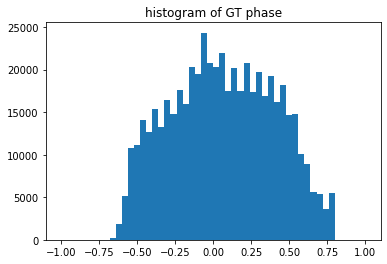

In [65]:

## objectAmplitude와 phase에 이미지 로드, size_obj로 리사이즈 해준다.
objectAmplitude = np.array(Image.open('./cameraman.tif'))
objectAmplitude=cv2.resize(objectAmplitude,(HR_obj_size_x,HR_obj_size_y),interpolation=cv2.INTER_CUBIC )
objectAmplitude=objectAmplitude+np.mean(objectAmplitude)/10
objectAmplitude=objectAmplitude/np.max(objectAmplitude)

phase = np.array(Image.open('./westconcordorthophoto.png'))
# phase = phase.resize((HR_obj_size_x,HR_obj_size_y))
phase=cv2.resize(phase,(HR_obj_size_x,HR_obj_size_y),interpolation=cv2.INTER_CUBIC )
phase_scale_factor=4 # determines maximum phase value [-pi/(phase_scale_factor),pi/(phase_scale_factor)]
phase = phase/(np.max(phase)*phase_scale_factor)
phase = phase-(1/(phase_scale_factor*2))
object_function = objectAmplitude*np.exp(1j*2*np.pi*(phase))

## figures for complex object field
plt.figure(1)
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.imshow(np.absolute(object_function),cmap='gray')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(np.angle(object_function),cmap='gray')
plt.colorbar()
plt.show()

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.imshow(np.log(np.abs(F(object_function)))+0.00001,cmap='gray')
plt.show()

plt.figure(3)
plt.hist(np.reshape(np.angle(object_function),(HR_obj_size_x*HR_obj_size_y,1)),50,[-1,1])
plt.title('histogram of GT phase')
plt.show()


2. Create the wave vectors for the LED illumiantion 

In [66]:
xlocation = np.zeros((1,arraysize**2));
ylocation = np.zeros((1,arraysize**2));

for i in range (0,arraysize):# from top left to bottom right
    for k in range(0,arraysize):
        xlocation[0,k+arraysize*(i)] = (((1-arraysize)/2)+k)*LEDgap
        ylocation[0,k+arraysize*(i)] = ((arraysize-1)/2-(i))*LEDgap

        

## Relative Fourier Domain location of LED array
kx_relative = -np.sin(np.arctan(xlocation/LEDheight));  
ky_relative = -np.sin(np.arctan(ylocation/LEDheight)); 


3. Generate the low-pass filtered images

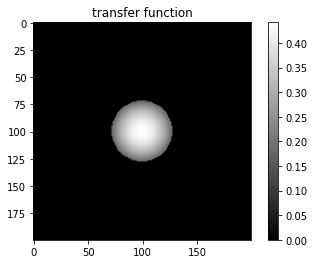

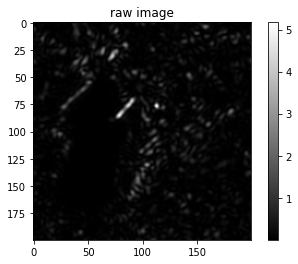

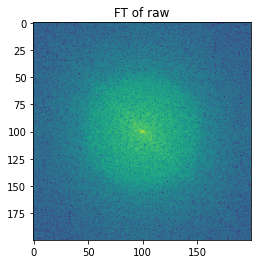

145.0


In [72]:





imSeqLowRes = np.zeros((sensor_size_x, sensor_size_y, arraysize**2)); #the final low resolution image sequence
kx = k0 * kx_relative;                 
ky = k0 * ky_relative;
dkx = 2*np.pi/(psize*HR_obj_size_x);
dky = 2*np.pi/(psize*HR_obj_size_y);
cutoffFrequency = NA * k0;
kmax = np.pi/spsize


# sampled_x=int(m1*r_cam)
# sampled_y=int(n1*r_cam)
# sampled_img = np.zeros((sampled_x, sampled_y, arraysize**2)); #the final low resolution image sequence

#Generate lens aberation using zernike polynomial
W=4*optool.zernike_nm(4, 0, sensor_size_x)+2*optool.zernike_nm(2, 0, sensor_size_x)
W=W/np.max(W)
##
kgrid_x=np.linspace(-kmax,kmax,sensor_size_x)
kgrid_y=np.linspace(-kmax,kmax,sensor_size_y)
[kxm, kym]= np.meshgrid(kgrid_x,kgrid_y)
CTF = np.exp(1j*W)*((kxm**2+kym**2)<cutoffFrequency**2) #pupil function circ(kmax);
# CTF = ((kxm**2+kym**2)<cutoffFrequency**2) #pupil function circ(kmax);


## Calculates with the thin sample assumption
objectFT = F(object_function)

## Low Resolution 묶음 만들기

for num_img in range (0,arraysize**2):
    kxc = int((HR_obj_size_x+1)/2+kx[0,num_img]/dkx)
    kyc = int((HR_obj_size_y+1)/2+ky[0,num_img]/dky)
    kxl=int((kxc-(sensor_size_x-1)/2))
    kxh=int((kxc+(sensor_size_x-1)/2))
    kyl=int((kyc-(sensor_size_y-1)/2))
    kyh=int((kyc+(sensor_size_y-1)/2))
    imSeqLowFT = objectFT[kyl:kyh+1,kxl:kxh+1]* CTF
    imSeqLowRes[:,:,num_img] = np.abs(Ft(imSeqLowFT))**2

    # add noise to the raw image 
    # noise level: 10% of raw image
#     noise = np.random.normal(np.mean(imSeqLowRes[:,:,num_img])*0.1, 10, (sensor_size_x, sensor_size_y)) 
#     imSeqLowRes[:,:,num_img]=imSeqLowRes[:,:,num_img]+noise  
#     imSeqLowRes[:,:,num_img]=imSeqLowRes[:,:,num_img]*(imSeqLowRes[:,:,num_img]>0)   
#     ## 촬영되는 이미지를 저장하려면
#     plt.imsave('./tmp/image_'+str(tt)+'.png',imSeqLowRes[:,:,tt])


# transfer function
plt.figure(1)
plt.imshow(np.angle(CTF),cmap='gray')
plt.title('transfer function')
plt.colorbar()
plt.show()

# raw image
plt.figure(2)
plt.imshow(imSeqLowRes[:,:,112],cmap='gray')
plt.title('raw image')
plt.colorbar()
plt.show()

# FT of raw image
FT_raw=(F(np.sqrt(imSeqLowRes[:,:,112])))
FT_raw_logscale=np.log(np.abs(FT_raw)+0.0000000001)
plt.figure(3)
plt.imshow(FT_raw_logscale)
plt.title('FT of raw')
plt.show()

print((arraysize**2+1)/2)


# mask=np.zeros((m1, n1))
# for i in range (1,m1-1):
#     for j in range (1,n1-1):
#         if (np.mod(i,2)==0 & np.mod(j,2)==1):
#             mask[i,j]=1
#         elif ((np.mod(i,2)==1) & (np.mod(j,2)==0)):
#             mask[i,j]=1
#             anti_imSeq[i,j,:]=sampled_img[int((i+1)/2),int(j/2),:]

In [73]:
            
# m1=sampled_x
# n1=sampled_y
    
# spsize=0.9e-6
# cutoffFrequency = NA * k0;
# kmax = np.pi/spsize
# kxm=np.zeros((m1,n1))
# kym=np.zeros((m1,n1))

# ##
# instx=np.linspace(-kmax,kmax,m1)
# insty=np.linspace(-kmax,kmax,n1)
# [kxm, kym]= np.meshgrid(instx,insty)
# CTF = ((kxm**2+kym**2)<cutoffFrequency**2); #pupil function circ(kmax);
# plt.imshow(CTF,cmap='gray')
# plt.colorbar()
# plt.show()

**Simulate the recovering process to  high resolution image**

1. Make a sequence


In [74]:
def gseq(arraysize):

  n=(arraysize+1)/2;
  sequence=np.zeros((2,arraysize**2))
  sequence[0,0]=n;
  sequence[1,0]=n;			
  dx=+1;
  dy=-1;
  stepx=+1;
  stepy=-1;
  direction=+1;
  counter=0;
  
  for i in range (1,arraysize**2):
      counter=counter+1;
      if (direction==+1):
          sequence[0,i]=sequence[0,i-1]+dx;
          sequence[1,i]=sequence[1,i-1];
          if (counter==abs(stepx)):
              counter=0;
              direction=direction*-1;
              dx=dx*-1;
              stepx=stepx*-1;
              if stepx>0:
                  stepx=stepx+1;
              else:
                  stepx=stepx-1;

      else:
          sequence[0,i]=sequence[0,i-1];
          sequence[1,i]=sequence[1,i-1]+dy;
          if (counter==abs(stepy)):
              counter=0;
              direction=direction*-1;
              dy=dy*-1;
              stepy=stepy*-1;
              if (stepy>0):
                  stepy=stepy+1;
              else:
                  stepy=stepy-1;

  seq=(sequence[0,:]-1)*arraysize+sequence[1,:]
  return seq


2. Recover high resolution image

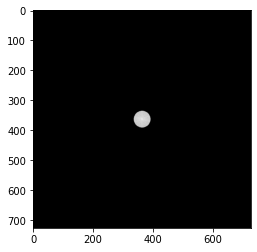

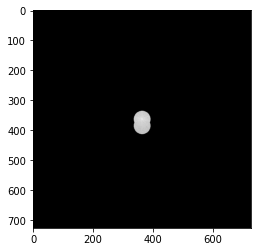

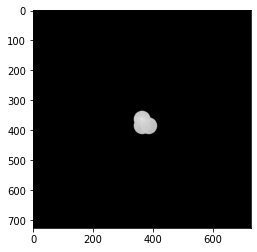

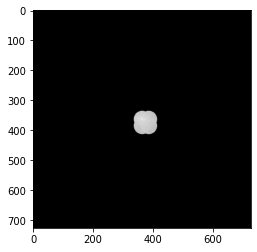

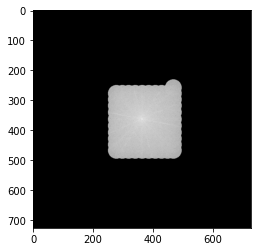

In [75]:


seq=gseq(arraysize)
objectRecover = np.ones((HR_obj_size_x,HR_obj_size_y));

objectRecoverFT = F(objectRecover);

alpha_obj=0.1;
gamma_obj=1;
alpha_Pup=1;
gamma_Pup =1;

Pup=CTF
loop = 20;
for loop_num in range (0,loop):
    for num_img in range(0,arraysize**2):
        reordered_num_img=int(seq[num_img]-1) # reorder for faster convergence
        kxc = int((HR_obj_size_x+1)/2+kx[0,reordered_num_img]/dkx)
        kyc = int((HR_obj_size_y+1)/2+ky[0,reordered_num_img]/dky)
        kxl=int((kxc-(sensor_size_x-1)/2))
        kxh=int((kxc+(sensor_size_x-1)/2))
        kyl=int((kyc-(sensor_size_y-1)/2))
        kyh=int((kyc+(sensor_size_y-1)/2))
        Objfcrop=objectRecoverFT[kyl:kyh+1,kxl:kxh+1]
        ObjfcropP = Objfcrop* Pup
        im_lowRes = Ft(ObjfcropP);
        im_lowRes = np.sqrt(imSeqLowRes[:,:,reordered_num_img])*(im_lowRes)/abs(im_lowRes)
        Objfup=F(im_lowRes)
        #recover pupil
#         Pup = Pup + (gamma_Pup)*np.conj(Objfcrop)* (Objfup - ObjfcropP)/ ((1-alpha_Pup)*np.abs(Objfcrop)**2 +(alpha_Pup)*np.max(np.abs(Objfcrop)**2))
        objectRecoverFT[kyl:kyh+1,kxl:kxh+1] = objectRecoverFT[kyl:kyh+1,kxl:kxh+1]+gamma_obj*np.conj(Pup)*(Objfup - ObjfcropP) / ((1-alpha_obj)*np.abs(Pup)**2 +(alpha_obj)*np.max(np.abs(Pup)**2));
        if (loop_num == 0) and (num_img == 0 or num_img == 1 or num_img == 2 or num_img == 3 or num_img == 100):
            plt.imshow(np.log(0.00000001+np.absolute(objectRecoverFT)),cmap='gray')
            # plt.imshow(abs(np.fft.ifft2(np.fft.ifftshift(objectRecoverFT[kyl:kyh+1,kxl:kxh+1]*CTF))))
  
            plt.show()






**최종 확인 & 초기 이미지와의 비교**

<Figure size 432x288 with 0 Axes>

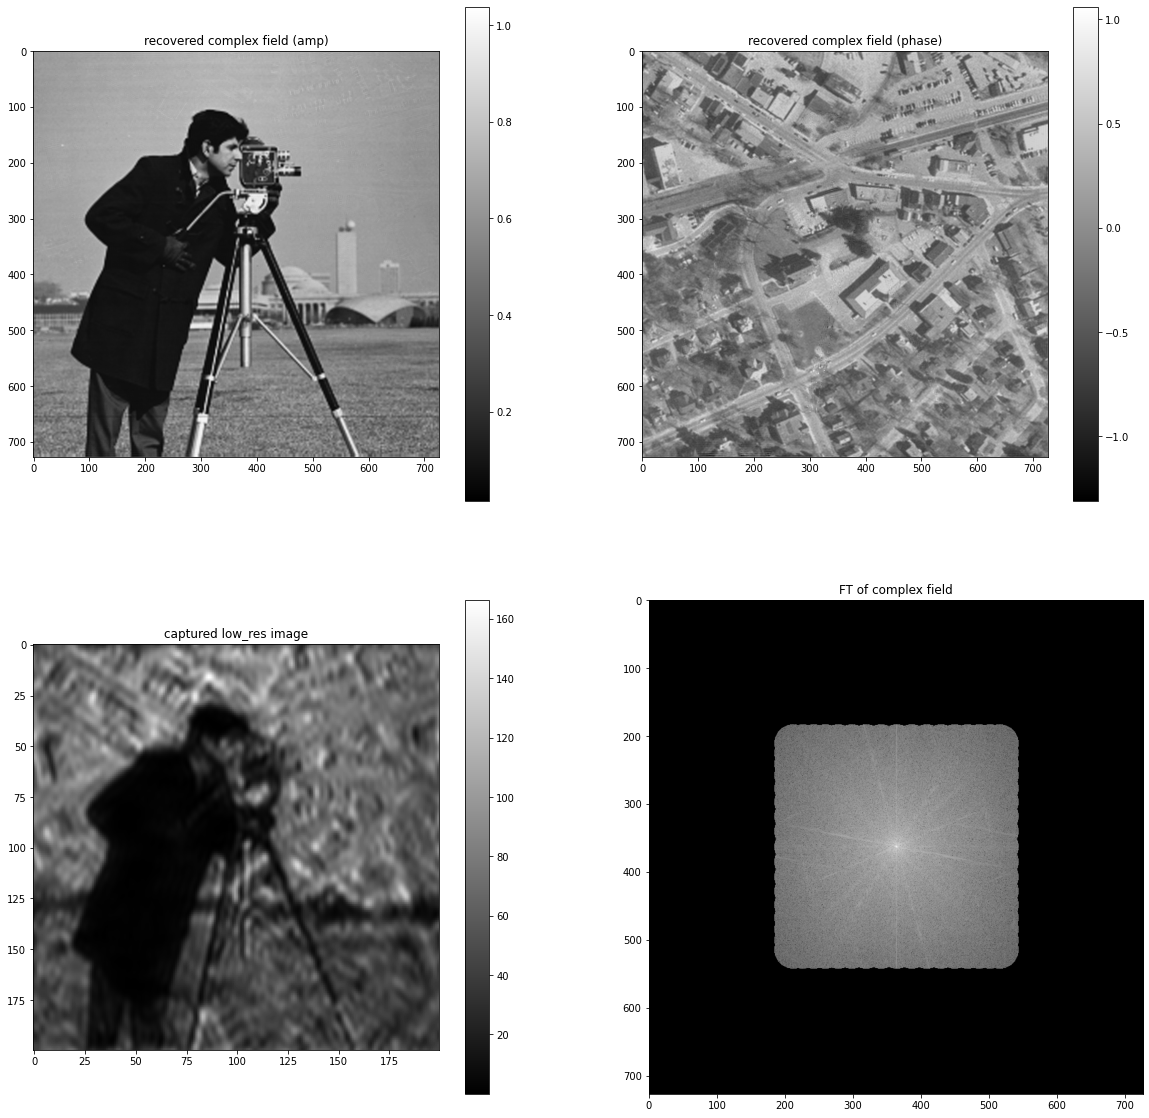

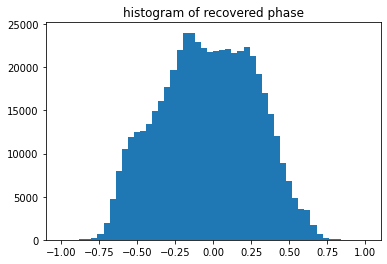

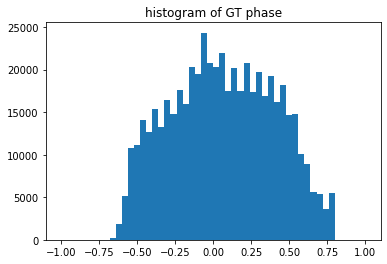

In [76]:
objectRecover=np.fft.ifft2(np.fft.ifftshift(objectRecoverFT));
plt.figure(2)
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(np.absolute(objectRecover),cmap='gray')
plt.title('recovered complex field (amp)')
plt.colorbar()
plt.subplot(222)
plt.imshow(np.angle(objectRecover),cmap='gray');
# plt.clim([0, np.pi])
plt.title('recovered complex field (phase)')
plt.colorbar()
plt.subplot(223)
plt.imshow(imSeqLowRes[:,:,int((arraysize**2+1)/2)],cmap='gray');
plt.title('captured low_res image')
plt.colorbar()
plt.subplot(224)
plt.imshow((np.log(0.01+np.absolute(objectRecoverFT))),cmap='gray');
plt.title('FT of complex field')
plt.show()
# kc=np.reshape(np.angle(objectRecover),(1,m*n))
# hist=np.histogram(kc)
# plt.hist(kc,100)
# plt.imshow(hist)
# plt.show()
plt.figure(3)
plt.hist(np.reshape(np.angle(objectRecover),(HR_obj_size_x*HR_obj_size_y,1)),50,[-1,1])
plt.title('histogram of recovered phase')
plt.figure(4)
plt.hist(np.reshape(np.angle(object_function),(HR_obj_size_x*HR_obj_size_y,1)),50,[-1,1])
plt.title('histogram of GT phase')
plt.show()